# START
The first cell below must always be run, regardless of if the pickle has already been created or not.

In [1]:
import pandas as pd
from bio_embeddings.embed import ProtTransBertBFDEmbedder
from tqdm.notebook import tqdm_notebook
tqdm_notebook.pandas()
from tqdm import tqdm
from sklearn.decomposition import PCA
import numpy as np

# STOP
Only run the cells below (until next markdown cell) if the sequences are being embedded with the embedder of choice. First make sure the 'embedder of choice' comment has been ammended before running, in addition to changing the file names for reading the excel file and subsequently saving the embedded data into a pickle. <br>
Scroll down to 'Resume' if you are intending to open a pickle.

In [ ]:
# Opening the requisite excel file into pandas dataframe. First two entries of the df are printed to check data is correct
df = pd.read_excel('Prelim and active site data.xlsx', engine='openpyxl')
df.reset_index(inplace=True, drop=True)
df.head(2)

In [ ]:
# Initially making a copy of the dataframe, then dropping entries which do not contain a value in the enantiomer column
# The shape is then checked to see how many entries remain
df = df.copy()
df.dropna(subset=['Enantiomer'], inplace=True)
df.shape

In [ ]:
# Using bioembeddings to embed the protein sequences, and saving the output data into a pickle file as it is a lengthy
# process to run the code (25 mins). The pickle file can be opened (vide infra) in the future to access the embeddings.
# DO NOT RUN
embedder = ProtTransBertBFDEmbedder()
df['as_embedding'] = df['ActiveSiteSequence'].progress_apply(embedder.embed)
df['as_em_per_protein'] = df['as_embedding'].progress_apply(embedder.reduce_per_protein)

df['cf_embedding'] = df['CofactorSiteSequence'].progress_apply(embedder.embed)
df['cf_em_per_protein'] = df['cf_embedding'].progress_apply(embedder.reduce_per_protein)

df.to_pickle('Active site and cofactor ProtTrans.pkl')
df.head(2)

# RESUME
In all instances where random_state is an argument, ensure the **same integer** is maintained for reproducibility purposes. <br> N.b. integer = 25

In [2]:
SEED=25

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier

from sklearn.metrics import f1_score, log_loss, roc_curve, auc, roc_auc_score
from sklearn.model_selection import cross_val_score, GridSearchCV

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc={'figure.figsize': (5, 5)})
sns.set(font_scale=1.5)
sns.set_style('whitegrid')
sns.set_theme()
%config InlineBackend.figure_format = 'retina'

In [6]:
df = pd.read_pickle('Active site and cofactor ProtTrans.pkl')
df.set_index('IRED No. ', inplace=True)
df.head(2)

,Reaction 2,ee,Enantiomer,enantiomer binary,Sequence,ActiveSiteSequence,CofactorSiteSequence,ActiveSiteCharge,NumOfAcidicRes,NumOfBasicRes,NumOfHisRes,AllActiveSiteRes,as_embedding,as_em_per_protein,cf_embedding,cf_em_per_protein
IRED No.,,,,,,,,,,,,,,,,
1,"62% (33% ee, S)",33.0,S,1.0,MSTKKVTVIGLGSLGSALAAALLRTGHDVTVWNRTPEKAEALVAQG...,WGMYASSINVALILSAVMAVPADLLLYGYL,WMASSIVAKIGLGSLGSALWNRTPEKVVCVFDTEAARELLNLTSGG...,-1.0,1.0,0.0,0.0,"[('204', 'TRP'), ('207', 'GLY'), ('208', 'MET'...","[[-0.038759723, -0.045219988, -0.046695713, 0....","[-0.047285475, -0.051240433, 0.019498985, 0.05...","[[-0.09923395, 0.09147623, -0.071297094, -0.06...","[0.018802157, -0.034770574, 0.023398558, -0.01..."
2,"67% (46% ee, S)",46.0,S,1.0,MTDTSAKLTLLGLGAMGSALATAWLAADYDITVWNRTASRAEPLRT...,WAMYTSNMMEGNMTMTGIMAVPPMDVLLSMTF,WTSNMEGTLLGLGAMGSALWNRTASRAACLLDDASVSTLNLTTGGG...,-2.0,2.0,0.0,0.0,"[('209', 'TRP'), ('212', 'ALA'), ('213', 'MET'...","[[-0.04628261, 0.012082437, -0.13582599, 0.026...","[-0.0033455293, -0.043854073, -0.018309927, -0...","[[0.055441324, 0.011702623, -0.11184296, 0.004...","[0.013172345, -0.022141414, -0.005940517, 0.00..."


In [7]:
X_as = list(df['as_em_per_protein']) 
X_cf = list(df['cf_em_per_protein'])
X_charge = list(df['ActiveSiteCharge'])
X_acid = list(df['NumOfAcidicRes'])
X_basic = list(df['NumOfBasicRes'])
X_his = list(df['NumOfHisRes'])
           
X = []
for i in range(0,len(X_as)):
    features = []
    features.extend(X_as[i])
    features.extend(X_cf[i])
    features.append(X_charge[i])
    features.append(X_acid[i])
    features.append(X_basic[i])
    features.append(X_his[i])
    X.append(features)

y = df['enantiomer binary']

#print(X[0])

In [8]:
# Splitting the data into training and test sets, remember the random_state argument!
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=SEED)

## k-Nearest Neighbours (k-NN)

In [9]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

y_pred_knn = knn.predict(X_test)

knn_accuracy = knn.score(X_test, y_test)
knn_f1 = f1_score(y_test, y_pred_knn)
knn_logloss = log_loss(y_test, y_pred_knn)

print('The knn accuracy is {:.3f}'.format(knn_accuracy));
print('The knn f1 score is {:.3f}'.format(knn_f1));
print('The knn log loss is {:.3f}'.format(knn_logloss))

The knn accuracy is 0.788
The knn f1 score is 0.867
The knn log loss is 7.306


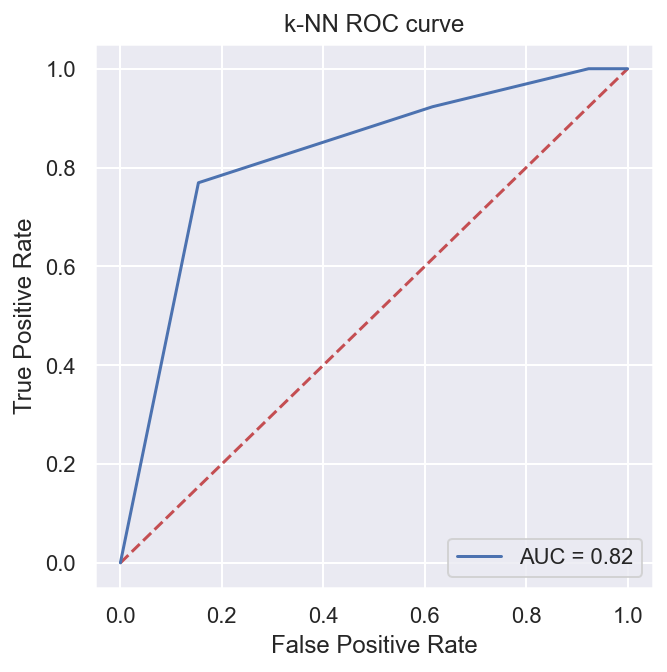

In [10]:
y_scores_knn = knn.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_scores_knn[:,1])

roc_auc = auc(fpr, tpr)

plt.plot([0,1], [0,1], 'r--')
plt.plot(fpr, tpr, label='AUC = %0.2f' %roc_auc)
plt.legend(loc='lower right')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('k-NN ROC curve')
plt.show();

In [11]:
knn_cv_scores = cross_val_score(knn, X, y, cv=10, scoring='f1')
knn_cv_mean = knn_cv_scores.mean()
knn_cv_std = knn_cv_scores.std()
print('The k-NN cross-validation mean is {:.3f}'.format(knn_cv_mean));
print('The k-NN cross-validation standard deviation is {:.3f}'.format(knn_cv_std))

The k-NN cross-validation mean is 0.828
The k-NN cross-validation standard deviation is 0.058


# Linear Regression

In [12]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)

logreg_accuracy = logreg.score(X_test, y_test)
logreg_f1 = f1_score(y_test, y_pred_logreg)
logreg_logloss = log_loss(y_test, y_pred_logreg)

print('The Logistic Regression accuracy is {:.3f}'.format(logreg_accuracy));
print('The Logistic Regression f1 score is {:.3f}'.format(logreg_f1));
print('The Logistic Regression log loss is {:.3f}'.format(logreg_logloss))

The Logistic Regression accuracy is 0.788
The Logistic Regression f1 score is 0.874
The Logistic Regression log loss is 7.306


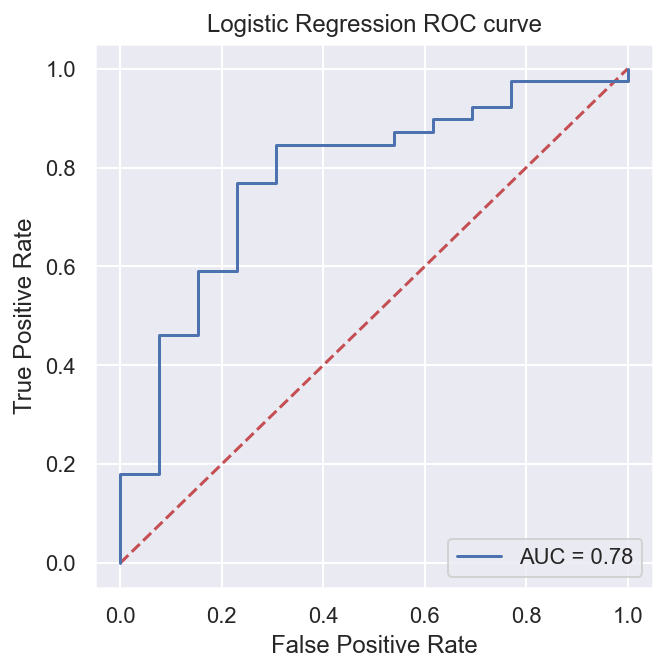

In [13]:
y_scores_logreg = logreg.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_scores_logreg[:,1])

roc_auc = auc(fpr, tpr)

plt.plot([0,1], [0,1], 'r--')
plt.plot(fpr, tpr, label='AUC = %0.2f' %roc_auc)
plt.legend(loc='lower right')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC curve')
plt.show();

In [14]:
logreg_cv_scores = cross_val_score(logreg, X, y, cv=10, scoring='f1')
logreg_cv_mean = logreg_cv_scores.mean()
logreg_cv_std = logreg_cv_scores.std()
print('The Logistic Regression cross-validation mean is {:.3f}'.format(logreg_cv_mean));
print('The Logistic Regression cross-validation standard deviation is {:.3f}'.format(logreg_cv_std))

The Logistic Regression cross-validation mean is 0.846
The Logistic Regression cross-validation standard deviation is 0.046


# Voting Classifier Ensemble

In [15]:
lr = LogisticRegression(random_state=SEED)
knn = KNeighborsClassifier()
dt = DecisionTreeClassifier(random_state=SEED)
classifiers = [('Logistic Regression', lr),('K Nearest Neighbours', knn),('Classification Tree', dt)]

## Soft voting

In [16]:
vc_soft = VotingClassifier(estimators=classifiers, voting='soft')
vc_soft.fit(X_train, y_train)
y_pred_soft = vc_soft.predict(X_test)

vc_soft_accuracy = vc_soft.score(X_test, y_test)
vc_soft_f1 = f1_score(y_test, y_pred_soft)
vc_soft_logloss = log_loss(y_test, y_pred_soft)

print('The Voting Classifier (soft) accuracy is {:.3f}'.format(vc_soft_accuracy));
print('The Voting Classifier (soft) f1 score is {:.3f}'.format(vc_soft_f1));
print('The Voting Classifier (soft) log loss is {:.3f}'.format(vc_soft_logloss))

The Voting Classifier (soft) accuracy is 0.788
The Voting Classifier (soft) f1 score is 0.867
The Voting Classifier (soft) log loss is 7.306


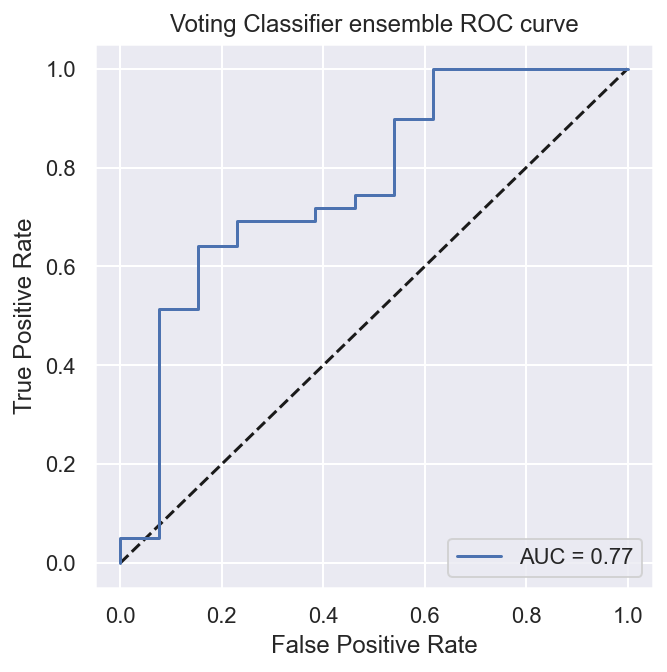

In [17]:
y_scores_soft = vc_soft.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_scores_soft[:,1])
roc_auc = auc(fpr, tpr)

y_pred_prob = vc_soft.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr, label='AUC = %0.2f' %roc_auc)
plt.legend(loc='lower right')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Voting Classifier ensemble ROC curve')
plt.show();

In [18]:
soft_cv_scores = cross_val_score(vc_soft, X, y, cv=10, scoring='f1')
soft_cv_mean = soft_cv_scores.mean()
soft_cv_std = soft_cv_scores.std()
print('The Voting Classifier (soft) cross-validation mean is {:.3f}'.format(soft_cv_mean));
print('The Voting Classifier (soft) cross-validation standard deviation is {:.3f}'.format(soft_cv_std))

The Voting Classifier (soft) cross-validation mean is 0.896
The Voting Classifier (soft) cross-validation standard deviation is 0.036


## Hard voting

In [19]:
vc_hard = VotingClassifier(estimators=classifiers, voting='hard')
vc_hard.fit(X_train, y_train)
y_pred_hard = vc_hard.predict(X_test)

vc_hard_accuracy = vc_hard.score(X_test, y_test)
vc_hard_f1 = f1_score(y_test, y_pred_hard)
vc_hard_logloss = log_loss(y_test, y_pred_hard)

print('The Voting Classifier (hard) accuracy is {:.3f}'.format(vc_hard_accuracy));
print('The Voting Classifier (hard) f1 score is {:.3f}'.format(vc_hard_f1));
print('The Voting Classifier (hard) log loss is {:.3f}'.format(vc_hard_logloss))

The Voting Classifier (hard) accuracy is 0.808
The Voting Classifier (hard) f1 score is 0.884
The Voting Classifier (hard) log loss is 6.642


In [20]:
hard_cv_scores = cross_val_score(vc_hard, X, y, cv=10, scoring='f1')
hard_cv_mean = hard_cv_scores.mean()
hard_cv_std = hard_cv_scores.std()
print('The Voting Classifier (hard) cross-validation mean is {:.3f}'.format(hard_cv_mean));
print('The Voting Classifier (hard) cross-validation standard deviation is {:.3f}'.format(hard_cv_std))

The Voting Classifier (hard) cross-validation mean is 0.880
The Voting Classifier (hard) cross-validation standard deviation is 0.043


# Bagging Classifier

In [21]:
dt_bag = DecisionTreeClassifier(max_depth=4, min_samples_leaf=0.16, random_state=SEED)
bc = BaggingClassifier(dt_bag, n_estimators=300, n_jobs=-1)

bc.fit(X_train, y_train)
y_pred_bag = bc.predict(X_test)

bag_accuracy = bc.score(X_test, y_test)
bag_f1 = f1_score(y_test, y_pred_bag)
bag_logloss = log_loss(y_test, y_pred_bag)

print('The Bagging Classifier accuracy is {:.3f}'.format(bag_accuracy));
print('The Bagging Classifier f1 score is {:.3f}'.format(bag_f1));
print('The Bagging Classifier log loss is {:.3f}'.format(bag_logloss))

The Bagging Classifier accuracy is 0.750
The Bagging Classifier f1 score is 0.857
The Bagging Classifier log loss is 8.635


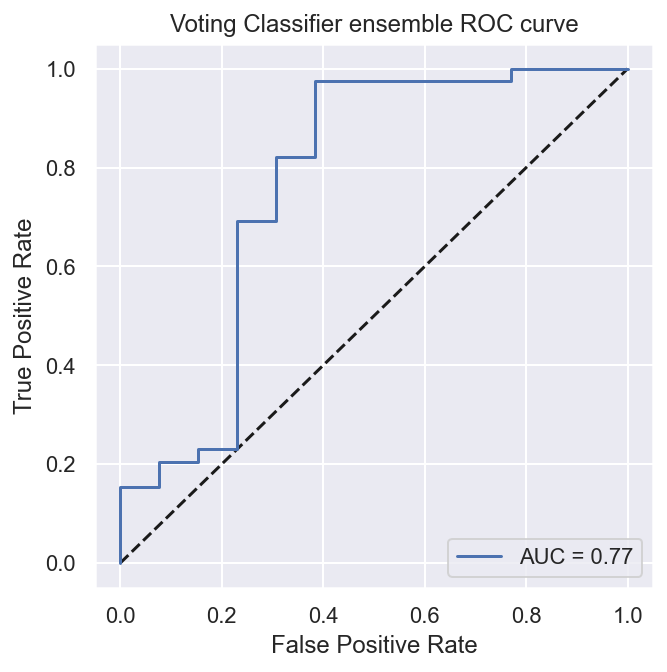

In [22]:
y_scores_bag = bc.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_scores_bag[:,1])

roc_auc = auc(fpr, tpr)
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr, label='AUC = %0.2f' %roc_auc)
plt.legend(loc='lower right')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Voting Classifier ensemble ROC curve')
plt.show();

In [23]:
bag_cv_scores = cross_val_score(bc, X, y, cv=10, scoring='f1')
bag_cv_mean = bag_cv_scores.mean()
bag_cv_std = bag_cv_scores.std()
print('The Bagging Classifier cross-validation mean is {:.3f}'.format(bag_cv_mean));
print('The Bagging Classifier cross-validation standard deviation is {:.3f}'.format(bag_cv_std))

The Bagging Classifier cross-validation mean is 0.863
The Bagging Classifier cross-validation standard deviation is 0.016


# XGBoost

## Data manipulation, fitting, evaluation (accuracy, f1, log loss)

In [28]:
import xgboost as xgb
#X = df[['cf_em_per_protein', 'ActiveSiteCharge', 'NumOfAcidicRes', 'NumOfBasicRes', 'NumOfHisRes']]
#y = df['enantiomer binary']

X_trainNPArray = np.array(X_train); X_testNPArray = np.array(X_test)
y_trainNPArray = np.array(y_train); y_testNPArray = np.array(y_test)

X_train_xgb = np.vstack(X_trainNPArray); X_test_xgb = np.vstack(X_testNPArray)
y_train_xgb = np.vstack(y_trainNPArray); y_test_xgb = np.vstack(y_testNPArray)

xgb_model = xgb.XGBClassifier(objective='binary:logistic', n_estimators=10, seed=SEED, use_label_encoder=False)

xgb_model.fit(X_train_xgb,y_train_xgb)

y_pred_xgb = xgb_model.predict(X_test_xgb)
xgb_accuracy = xgb_model.score(X_test_xgb, y_test_xgb)
xgb_f1 = f1_score(y_testNPArray, y_pred_xgb)
xgb_logloss = log_loss(y_test_xgb, y_pred_xgb)

print('The XGBoost accuracy is {:.3f}'.format(xgb_accuracy));
print('The XGBoost f1 score is {:.3f}'.format(xgb_f1));
print('The XGBoost log loss is {:.3f}'.format(xgb_logloss))

[13:40:21] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
The XGBoost accuracy is 0.769
The XGBoost f1 score is 0.864
The XGBoost log loss is 7.971


## AUC-ROC

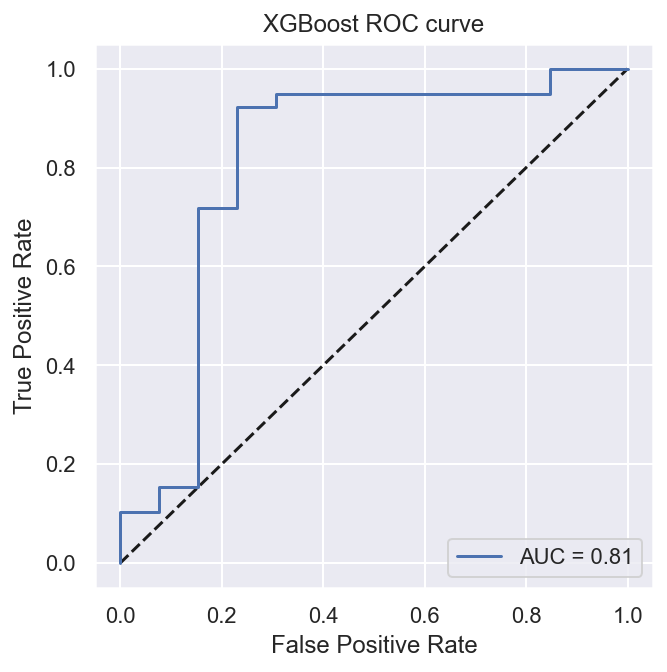

In [29]:
y_scores_xgb = xgb_model.predict_proba(X_test_xgb)
fpr, tpr, threshold = roc_curve(y_test_xgb, y_scores_xgb[:,1])

roc_auc = auc(fpr, tpr)
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr, label='AUC = %0.2f' %roc_auc)
plt.legend(loc='lower right')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost ROC curve')
plt.show();

## Cross-validation

In [27]:
xgb_cv = cross_val_score(xgb_model, np.vstack(X), np.vstack(y), cv=10, scoring='f1')
xgb_cv_mean = xgb_cv.mean()
xgb_cv_std = xgb_cv.std()
print('The XGBoost cross-validation mean is {:.3f}'.format(xgb_cv_mean));
print('The XGBoost cross-validation standard deviation is {:.3f}'.format(xgb_cv_std))

[13:40:15] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:40:15] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:40:16] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:40:16] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607